In [1]:
import scipy.io
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
from IPython.display import clear_output, display

# Set matplotlib to inline or widget if preferred, but inline is standard
%matplotlib inline

In [3]:
mat_file = 'mill.mat'
csv_file = 'mill_interactive.csv'

print(f"Loading {mat_file}...")
try:
    mat = scipy.io.loadmat(mat_file)
    # Clean metadata
    mat = {k: v for k, v in mat.items() if k[0] != '_'}
    print("Loaded successfully.")
except Exception as e:
    print(f"Error loading .mat file: {e}")
    mat = {}

Loading mill.mat...
Loaded successfully.


In [4]:
measurements = {} 
data_info = {}    

# Initialize Defaults
current_start = 2000
current_end = 7200

# Hardcoded signal names for display
signal_names_display = ["smcAC", "smcDC", "vib_table", "vib_spindle", "AE_table", "AE_spindle"]

Experiment 167 / 167
Process Info: [np.uint8(16), np.uint8(6), np.float64(0.62), np.uint8(9), np.float64(1.5), np.float64(0.5), np.uint8(2)]
Current Range: Start=1800, End=7000


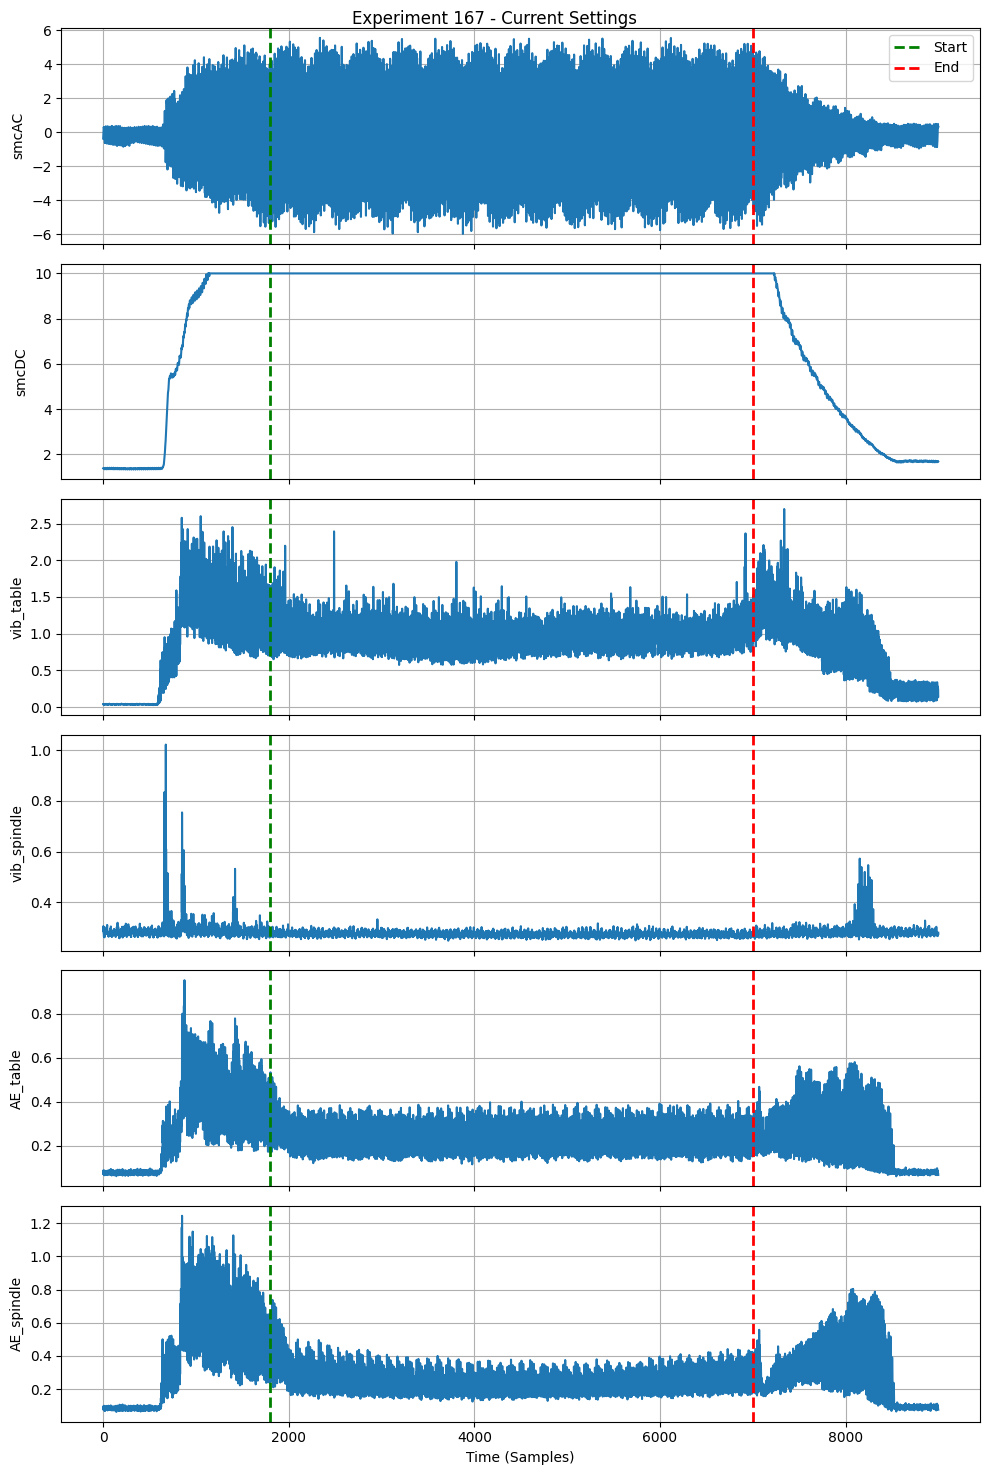

Enter new indices to update, or press Enter to verify and confirm current settings.
All experiments processed.


In [5]:
for key, value in mat.items():
    experiments_array = value[0] 
    total_experiments = len(experiments_array)
    
    print(f"Found {total_experiments} experiments under key '{key}'.")
    
    for i in range(total_experiments):
        sub_arr = experiments_array[i] 
        
        scalars = []
        signals = {} 
        
        for sub_index in range(len(sub_arr)):
            item = sub_arr[sub_index]
            if len(item) == 1:
                val = item[0][0]
                scalars.append(val)
            else:
                signals[sub_index] = item.flatten()
        
        sorted_signal_indices = sorted(signals.keys())
        
        # Interactive Loop
        confirmed = False
        while not confirmed:
            
            # --- PHASE 1: Plot Current & Ask for Changes ---
            clear_output(wait=True)
            print(f"========================================")
            print(f"Experiment {i+1} / {total_experiments}")
            print(f"Process Info: {scalars}")
            print(f"Current Range: Start={current_start}, End={current_end}")
            print(f"========================================")
            
            fig, axes = plt.subplots(len(sorted_signal_indices), 1, figsize=(10, 15), sharex=True)
            if len(sorted_signal_indices) == 1:
                axes = [axes]
            
            for idx, sig_idx in enumerate(sorted_signal_indices):
                ax = axes[idx]
                ax.plot(signals[sig_idx])
                
                # Draw Cut Lines
                ax.axvline(x=current_start, color='g', linestyle='--', linewidth=2, label='Start')
                if current_end is not None:
                    ax.axvline(x=current_end, color='r', linestyle='--', linewidth=2, label='End')
                
                label_name = signal_names_display[idx] if idx < len(signal_names_display) else f"Signal {idx}"
                ax.set_ylabel(label_name)
                ax.grid(True)
                if idx == 0:
                    ax.legend()
            
            axes[-1].set_xlabel("Time (Samples)")
            plt.suptitle(f"Experiment {i+1} - Current Settings")
            plt.tight_layout()
            plt.show()
            
            print("Enter new indices to update, or press Enter to verify and confirm current settings.")
            s_in = input("Enter Start Index [Press Enter to keep current]: ").strip()
            if s_in:
                try:
                    current_start = int(s_in)
                except ValueError:
                    print("Invalid start index. Using previous.")
            
            e_in = input("Enter End Index [Press Enter to keep current]: ").strip()
            if e_in:
                try:
                    current_end = int(e_in)
                except ValueError:
                    print("Invalid end index. Using previous.")
            
            if s_in or e_in:
                # If they changed something, we loop back to show it again.
                continue
                
            conf = input("Are these cuts correct? (y/n) [y]: ").strip().lower()
            if conf in ['', 'y', 'yes']:
                confirmed = True
            else:
                # If they say no, we just loop back
                pass

        # Store the data
        data_info[i] = scalars
        if i not in measurements:
            measurements[i] = {}
        
        for sig_idx in sorted_signal_indices:
            original_signal = sub_arr[sig_idx]
            sliced_signal = original_signal[current_start:current_end]
            measurements[i][sig_idx] = sliced_signal
            
print("All experiments processed.")

In [6]:
print("Building CSV...")

counter = 0
data_expanded = {}

# Iterate in sorted order
for k in sorted(data_info.keys()):
    first_sig_idx = list(measurements[k].keys())[0]
    signal_len = len(measurements[k][first_sig_idx])
    
    for t in range(signal_len):
        row = []
        row.extend(data_info[k])
        
        for sig_idx in sorted(measurements[k].keys()):
            val = measurements[k][sig_idx][t][0]
            row.append(val)
            
        data_expanded[counter] = row
        counter += 1
        
print("Creating DataFrame...")
cols = ['case','run','VB', 'time','DOC',"feed", "material", 
        "smcAC","smcDC","vib_table","vib_spindle","AE_table","AE_spindle"]

df = pd.DataFrame.from_dict(data_expanded, orient='index', columns=cols)

print("Sorting values...")
try:
    df = df.sort_values(['case','run','time'])
except KeyError:
    print("Warning: Could not sort by case/run/time.")

print(f"Saving to {csv_file}...")
df.to_csv(csv_file, sep=';', decimal='.')
print("Done!")

Building CSV...
Creating DataFrame...
Sorting values...
Saving to mill_interactive.csv...
Done!
